In [1]:
#Import Required libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16
import tensorflow as tf


import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt


import math
import matplotlib
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D


%matplotlib inline

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model, load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,GlobalAveragePooling2D,Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications import ResNet50, MobileNet, Xception, DenseNet121
from sklearn.metrics import fbeta_score

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

Using TensorFlow backend.


In [2]:
# Define the model paramters here

INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.1
EPOCHS = 25
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 5 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

TRAIN_PATH = 'train-jpg'
TEST_PATH = 'test-jpg'

TRAIN_CSV_PATH = 'train_v2.csv'
TEST_CSV_PATH = 'sample_submission_v2.csv'

In [3]:
# Construct dataframes holding training and test data information
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print()
print(df_test.head())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road

   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [6]:
# These files are numpy Arrays with shape Nx1
X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist())

In [8]:
# There are 17 Labels and each image is tagged with multiple labels
# Lets print out the unique label list

labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


We can see the difference between image resolution.
We did this plot to identify which is the best resolution to take.
32x32 seems very low. Best best is 128x128

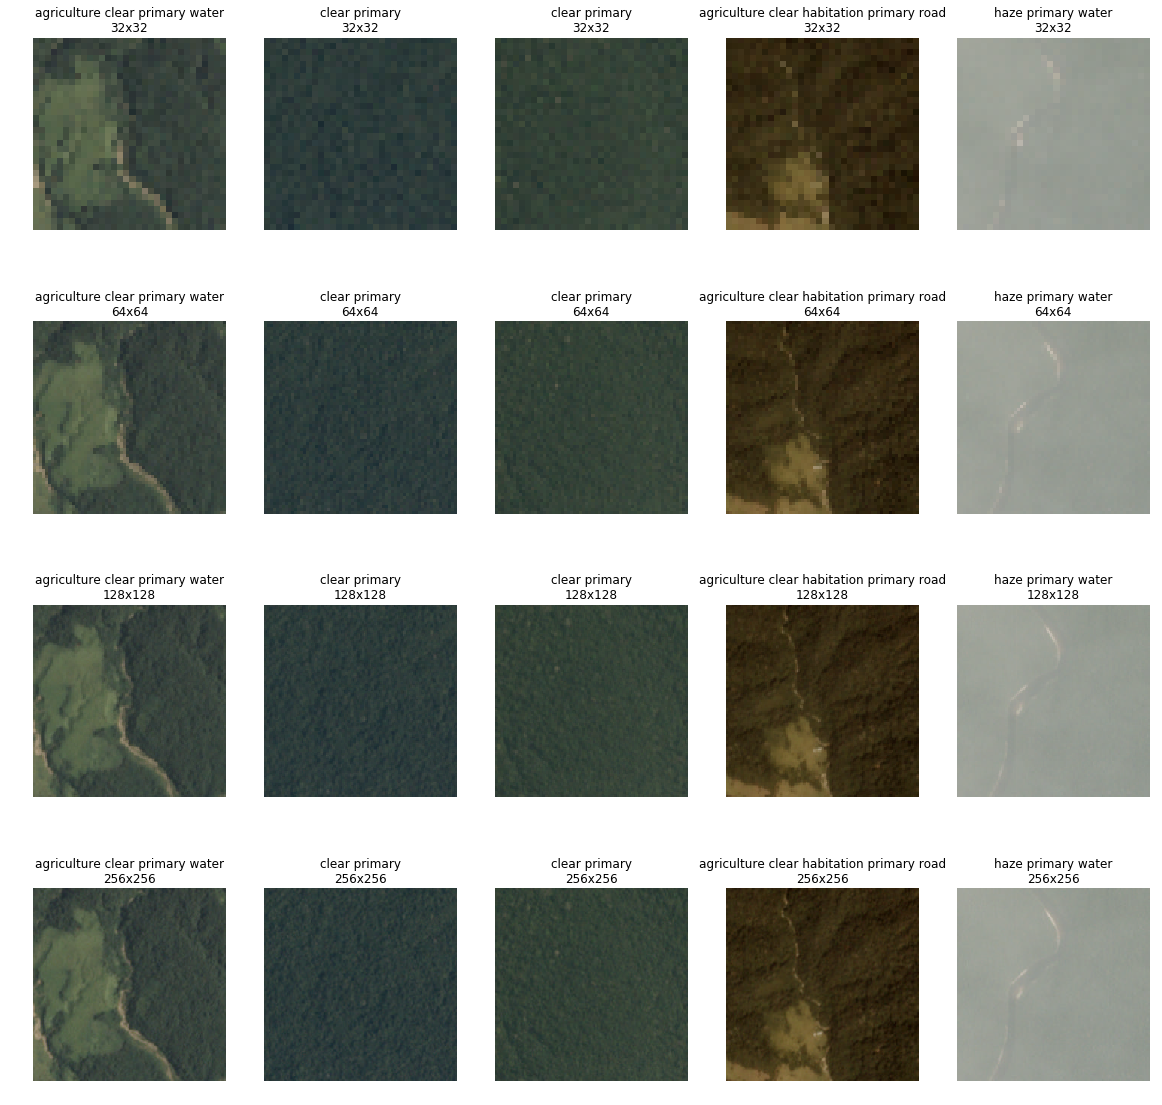

In [9]:
#Check some random images for quality check

plt.figure(figsize=(20, 20))
res = [32, 64, 128, 256]
NIMGS = 5

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(TRAIN_PATH, df_train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]))
        plt.axis('off')
    
plt.show()

conventional_mine is tagged least no of times: 99
primary is tagged max no of times: 37512


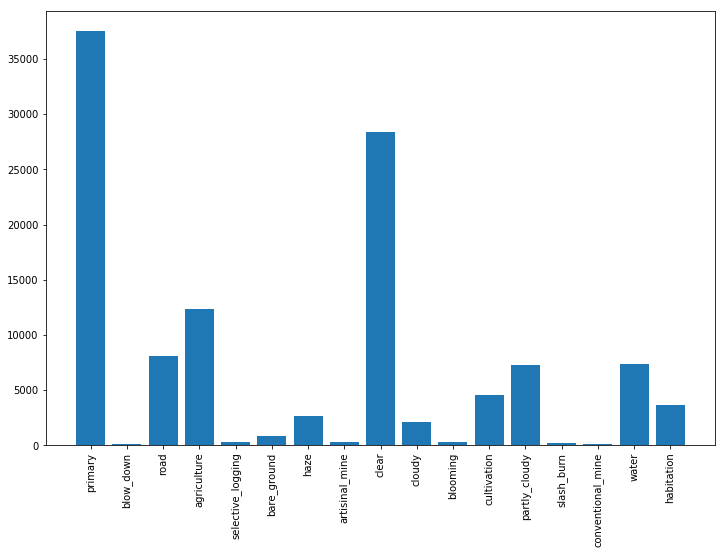

In [10]:
#Distribution of the labels :

plt.figure(figsize=(12, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [11]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [12]:
#Define CNN model architecture:

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Flatten(),

#         Dense(1024, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])

#     optimizer = SGD(lr=0.01, momentum=0.9)   # try 1 iteration with adam
    optimizer = Adam(0.001, decay=0.0001)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score_K])
    return model

model = create_model()

# model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[fbeta_score_K])
clear_session()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [13]:
#Run the model  with k-fold cross validation:

EPOCHS = 25

y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='fbeta_score_K', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
    y_test.append(p_test)
    num_fold+=1

Found 32383 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Found 61191 validated image filenames belonging to 17 classes.
Epoch 1/25
253/253 [==============================] - 281s 1s/step - loss: 0.2739 - fbeta_score_K: 0.5527 - val_loss: 0.2447 - val_fbeta_score_K: 0.5671
Epoch 2/25
253/253 [==============================] - 67s 266ms/step - loss: 0.2171 - fbeta_score_K: 0.6132 - val_loss: 0.2311 - val_fbeta_score_K: 0.6117
Epoch 3/25
253/253 [==============================] - 65s 258ms/step - loss: 0.2040 - fbeta_score_K: 0.6390 - val_loss: 0.2122 - val_fbeta_score_K: 0.6340
Epoch 4/25
253/253 [==============================] - 65s 259ms/step - loss: 0.1905 - fbeta_score_K: 0.6646 - val_loss: 0.1862 - val_fbeta_score_K: 0.6700
Epoch 5/25
253/253 [==============================] - 65s 258ms/step - loss: 0.1802 - fbeta_score_K: 0.6852 - val_loss: 0.1518 - val_fbeta_score_K: 0.6763
Epoch 6/25
253/253 [===================

In [14]:
# Average the k results obtained from k-fold cross validation

result = np.array(y_test[0])
for i in range(1, NFOLDS):
    result += np.array(y_test[i])
result /= NFOLDS
result = pd.DataFrame(result, columns = labels)
result.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.038178,0.000535,0.002239,0.014914,0.001820,0.980504,0.000049,0.000097,0.030286,0.004621,0.001781,0.014666,0.999738,0.021991,0.004370,0.001078,0.048369
1,0.068485,0.000994,0.002128,0.049860,0.009634,0.972579,0.000002,0.000078,0.093530,0.007740,0.000132,0.031748,0.999992,0.028815,0.022898,0.003153,0.059701
2,0.127999,0.001722,0.004925,0.000042,0.001242,0.000462,0.003922,0.000960,0.061894,0.014643,0.000126,0.994561,0.994996,0.058375,0.000450,0.002324,0.131763
3,0.035933,0.000354,0.001041,0.013293,0.001967,0.890163,0.000007,0.000046,0.031379,0.002990,0.000161,0.126336,0.999970,0.020578,0.005862,0.000721,0.034502
4,0.118327,0.000925,0.003740,0.000005,0.000206,0.002550,0.304003,0.000287,0.033635,0.026285,0.002173,0.758019,0.677646,0.077943,0.000240,0.000612,0.104377


In [ ]:
#model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')

In [16]:
#Pickling the result_new df
import pickle
pickle1_out = open('result_mb_25.pickle', 'wb')
pickle.dump(result, pickle1_out, protocol=4)
pickle1_out.close()

In [17]:
# Create label prediction and kaggle submission file 

preds = []
for i in range(result.shape[0]):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.to_csv('submit.csv', index=False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


# KAGGLE score - 0.91165

In [18]:
result.to_csv("result_cnn.csv")